# Real World Example!

Wenn man nur die Grundkonzpete gesehen hat, dann wird es auf Anhieb nicht klar, was man mit diesem Framework anfangen kann. Deswegen wollen wir uns ein einfaches Beispiel ansehen, das einen echten Usecase darstellen kann.
Und wie wir gesehen haben, handelt es sich um ein Workflow-System. Deswegen wird das Beispiel natürlich einen Workflow nutzen...

Das Szenario: Wir machen einen KI-Chatbot für ein Restaurant. Dieser Chatbot soll Anfragen in natürlicher Sprache entgegen nehmen. Über den Chatbot kann der Benutzer Bestellungen abgeben oder Informationen wie z.B. Öffnungszeiten abrufen.

Lösung: Wir nutzen ein Agenten-System. Erstmal brauchen wir einen Agenten, der die Aufgabe hat die Absicht des Benutzers erkennt. Wir machen uns das Leben hier einfach, d.h. erlaubt ist entweder bestellen oder Infos abrufen.
Wenn der User Infos haben möchte, dann routen wir zu dem Info-Assistenten, der die Anfrage beantwortet.

Im Falle einer Bestellung müssen wir prüfen, ob wir alle Angaben haben. Wir müssen zum einen wissen, was der Benutzer bestellen möchte und außerdem wohin das Essen geliefert werden soll. Hierfür nutzen wir auch einen Agenten zur Prüfung. Falls Angaben fehlen, wird der Benutzer danach gefragt.

Wenn alles OK ist, dann wird der Bestell-Agent beauftrag die Bestellung für die Küche aufzubereiten. Dazu wird er ein Tool nutzen. In einer echten Anwendung wäre das z.B. eine Datenbank. Wir machen es hier aber recht einfach, in dem das Tool eine formatierte Ausgabe macht, in der alle wichtigen Angaben für die Küche enhalten sind.

Zu guter Letzt wird der Auftrag bestätigt und der Prozess ist beendet.

Schauen wir uns das als Diagramm mal an...

![Diagramm](./bilder/agent-flow.png)

Lasst uns die Anwendung sukzessive aufbauen. Wir fangen erstmal mit der üblichen Initialisierung und Installation an. Wir legen dann ein Datenmodell (_State_) an.
Dann legen wir jeden Agenten als Funktion (_Node_) an. Wir legen ausserdem das Tool an.

Zuletzt erstellen wir den Graph und verknüpfen alles zu einem Gesamtsystem.

In [ ]:
!pip install langgraph langchain_openai

In [15]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

model = ChatOpenAI(model="gpt-4o")

In [3]:
# State
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    missing_info: str

In [4]:
def ask_user(state: State):
    # Hier fragen wir den Nutzer, was er tun möchte
    return state

In [5]:
# Intent-Agent

def intent_agent(state: State):
    # Wir beauftragen die KI die Absicht des Nutzers zu erkennen: "info" oder "order"
    return "order"

In [6]:
def info_agent(state: State):
    # Dieser Agent beantwortet die Frage. Der Agent hat die notwendigen Informationen in seinem System-Prompt, um die Frage zu beantworten.
    return state

In [7]:
def accept_order_agent(state: State):
    # Dieser Agent nimmt die Bestellung entgegen.
    return state

In [8]:
def order_check_agent(state: State):
    # Dieser Agent überprüft, ob alle Angaben für die Bestellung vorhanden sind. Wenn nicht, dann antwortet er mit "incomplete". Wenn ja, dann antwortet er mit "complete".
    # Die Info, die noch fehlt, wird in der state gespeichert.
    return "complete"

In [9]:
def missing_info_agent(state: State):
    # Dieser Agent fragt nach der fehlenden Information.
    return state

In [10]:
def create_order_agent(state: State):
    # Dieser Agent erstellt die Bestellung mit dem Tool.
    return state

In [13]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("ask", ask_user)
graph_builder.add_node("info", info_agent)
graph_builder.add_node("accept_order", accept_order_agent)
graph_builder.add_node("missing_info_agent", missing_info_agent)
graph_builder.add_node("create_order", create_order_agent)

graph_builder.add_edge(START, "ask")
graph_builder.add_conditional_edges("ask", intent_agent, { "info": "info", "order": "accept_order" })
graph_builder.add_conditional_edges("accept_order", order_check_agent, { "complete": "create_order", "incomplete": "missing_info_agent" })
graph_builder.add_conditional_edges("missing_info_agent", order_check_agent, { "complete": "create_order", "incomplete": "missing_info_agent" })
graph_builder.add_edge("create_order", END)
graph_builder.add_edge("info", END)

graph = graph_builder.compile()

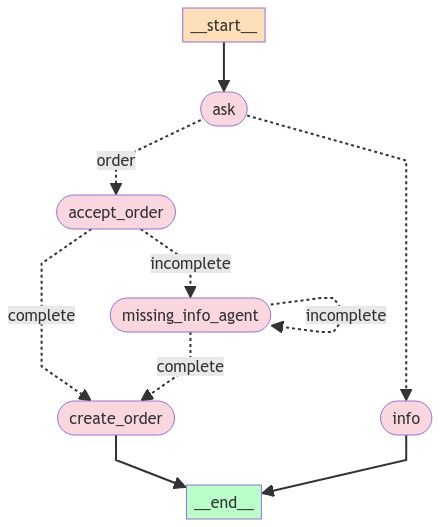

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))